## Введение

Данное соревнование организовано крупнейшим испанским банком Santander, цель задачи состоит в том, чтобы помочь построить алгоритм для выделения клиентов, которые будут совершать транзакцию по банковской карте в будущем, вне зависимости от суммы транзакции. Таким образом, мы решаем задачу бинарной классификации.

<img src="./images/assignment1_description.png" width=800 height=600 />

Согласно равилам соревнования, данные, предоставленные для этого конкурса, имеют __ту же структуру, что и реальные данные__, которые есть у компании для решения этой проблемы. Это очень важные комментарий, который дает намек / дает основание считать, что данные, с которыми мы будем работать в ходе соревнования являются искусственными / анонимизированными / сильно преобразованными от исходных данных. Каждая строка содержит 200 числовых значений, идентифицируемых только числом. Мы будем исследовать данные, подготовим их для модели, обучим модель и спрогнозируем целевое значение для теста.

In [1]:
import os
import warnings
from typing import List
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score

warnings.simplefilter("ignore")

## 1. Базовый анализ данных

In [9]:
path = "../data/santander-customer-transaction-prediction"
print(os.listdir(path))

train = pd.read_csv(f"{path}/train.csv")
test = pd.read_csv(f"{path}/test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

['assignment1_data.zip', 'test.csv', '.sample_submission.csv.icloud', 'train.csv']
train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


Обучающая и тестовая выборки одинаковы по объему, содержат 202 тыс. наблюдений и 201 признак.

## Data Exploration


In [10]:
train.head(n=3)

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  

[3 rows x 202 columns]

In [11]:
test.head(n=2)

ID_code    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0  test_0  11.0656  7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493  18.2675   
1  test_1   8.5304  1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196  18.6316   

    var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.7112   2.4669   4.3654   
1 -4.4131  ...  10.6165   8.8349   0.9403  10.1282  15.5765   0.4773  -1.4852   

   var_197  var_198  var_199  
0  10.7200  15.4722  -8.7197  
1   9.8714  19.1293 -20.9760  

[2 rows x 201 columns]

__Обучающая выборка содержит:__

* ID_code (строка, идентификатор записи);
* целевая переменная;
* 200 числовых переменных, названных от var_0 до var_199;

__Тестовая выборка содержит:__

* ID_code (строка, идентификатор записи);
* 200 числовых переменных, названных от var_0 до var_199;

Проверим данные более детально на факт наличия пропусков и распределения признаков.

In [12]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [13]:
check_missings(train)

Total NA-values = 0


ID_code target    var_0    var_1    var_2    var_3    var_4    var_5  \
Total         0      0        0        0        0        0        0        0   
Percent       0      0        0        0        0        0        0        0   
Types    object  int64  float64  float64  float64  float64  float64  float64   

           var_6    var_7  ...  var_190  var_191  var_192  var_193  var_194  \
Total          0        0  ...        0        0        0        0        0   
Percent        0        0  ...        0        0        0        0        0   
Types    float64  float64  ...  float64  float64  float64  float64  float64   

         var_195  var_196  var_197  var_198  var_199  
Total          0        0        0        0        0  
Percent        0        0        0        0        0  
Types    float64  float64  float64  float64  float64  

[3 rows x 202 columns]

In [14]:
check_missings(test)

Total NA-values = 0


ID_code    var_0    var_1    var_2    var_3    var_4    var_5  \
Total         0        0        0        0        0        0        0   
Percent       0        0        0        0        0        0        0   
Types    object  float64  float64  float64  float64  float64  float64   

           var_6    var_7    var_8  ...  var_190  var_191  var_192  var_193  \
Total          0        0        0  ...        0        0        0        0   
Percent        0        0        0  ...        0        0        0        0   
Types    float64  float64  float64  ...  float64  float64  float64  float64   

         var_194  var_195  var_196  var_197  var_198  var_199  
Total          0        0        0        0        0        0  
Percent        0        0        0        0        0        0  
Types    float64  float64  float64  float64  float64  float64  

[3 rows x 201 columns]

Набор данных для обучения и для предсказания заполнен целиком, пропущенных значений нет. Посмотрим на основные статистики.

In [15]:
def plot_stat_distribution(train: pd.Series, test: pd.Series):
    """
    Визуализация признака для обучающих и тестовых данных;

    Parameters
    ----------
    train: pandas.core.frame.Series
        Значение признака на обучении.

    test: pandas.core.frame.Series
        Значение признака на тесте.

    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    train.plot(ax=axes[0], color="#33137d")
    test.plot(ax=axes[1], color="#007539")
    plt.suptitle(f"Feature name - {train.name}")
    axes[0].set_title("Train Distribution")
    axes[1].set_title("Test Distribution")

    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    plt.axhline(0, color="red", linestyle="--", alpha=0.5)
    (train - test).plot(color="#33137d")
    plt.legend()

def plot_row_distribution(func: callable, train: pd.Series, test: pd.Series, axis: int = 1):
    """
    Визуализация распределения статистики по строке обучающих
    и тестовых данных.

    Parameters
    ----------
    func: callable
        Функция для вычисления статистики.

    train: pandas.core.frame.Series
        Значение признака на обучении.

    test: pandas.core.frame.Series
        Значение признака на тесте.

    axis: int, optional, default = 1
        Направление оси вдоль которой выполнять агрегацию данных.
        Значения могут быть: {0 or 'index', 1 or 'columns'}
        Опциональный параметр, по умолчанию, равен 1.

    """
    plt.figure(figsize=(15, 5))
    test = test.drop("ID_code", axis=1).copy()
    train = train.drop(["ID_code", "target"], axis=1).copy()
    test_stats = test.apply(func, axis=axis)
    train_stats = train.apply(func, axis=axis)

    plt.title("Distribution of mean values per row in the train and test set")
    sns.distplot(test_stats, color="#33137d", kde=True, bins=120, label='train')
    sns.distplot(train_stats, color="#007539", kde=True, bins=120, label='test')
    plt.xlabel(f"feature-{func}", size=13)
    plt.legend()
    plt.show()

In [16]:
train_stats = train.describe()
test_stats = test.describe()

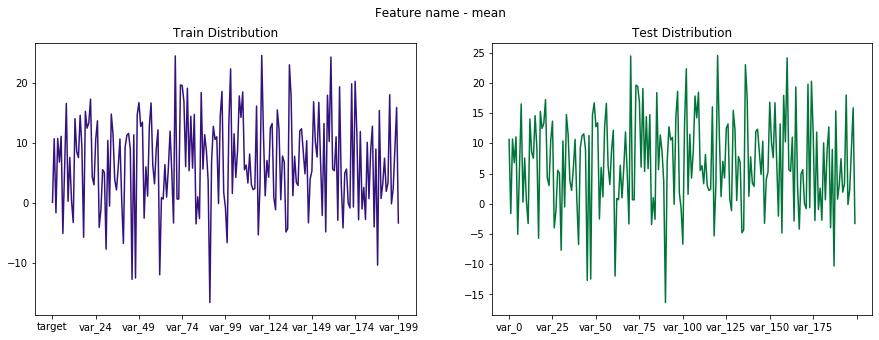

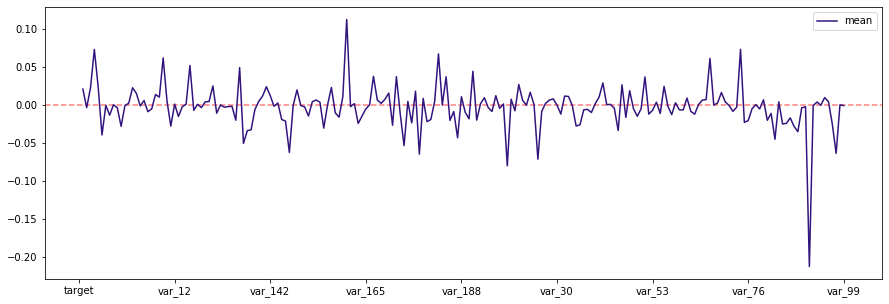

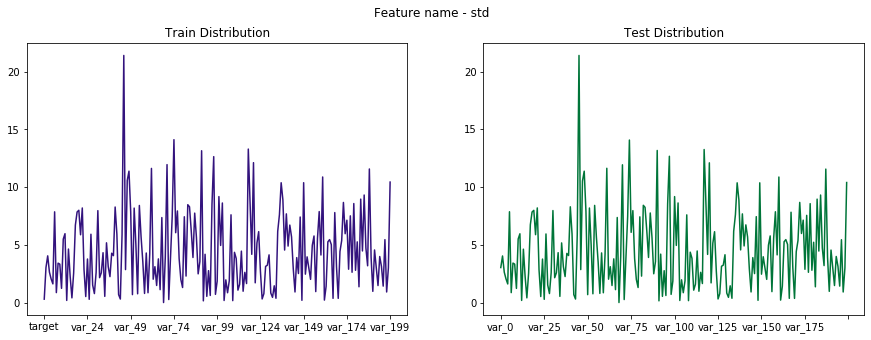

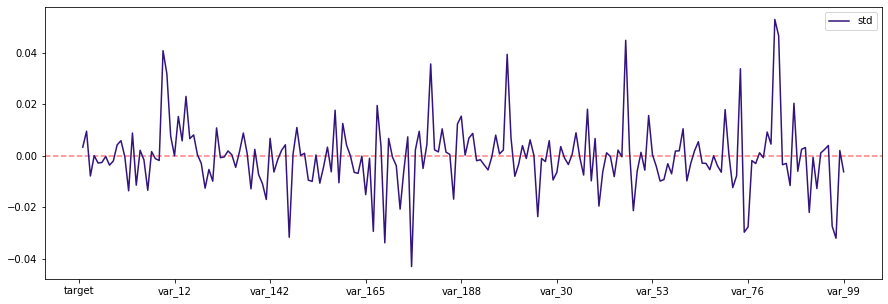

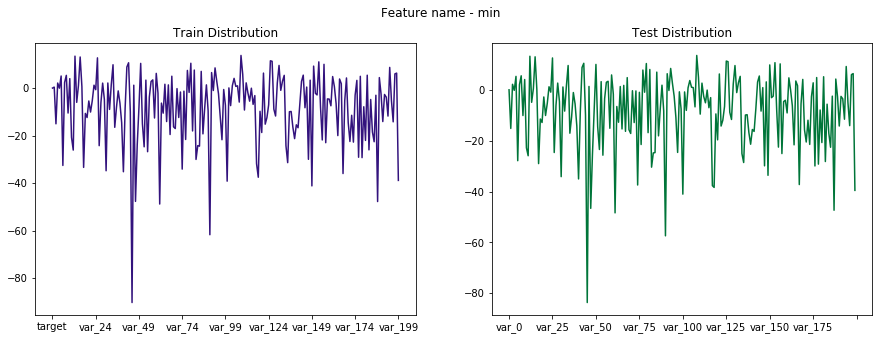

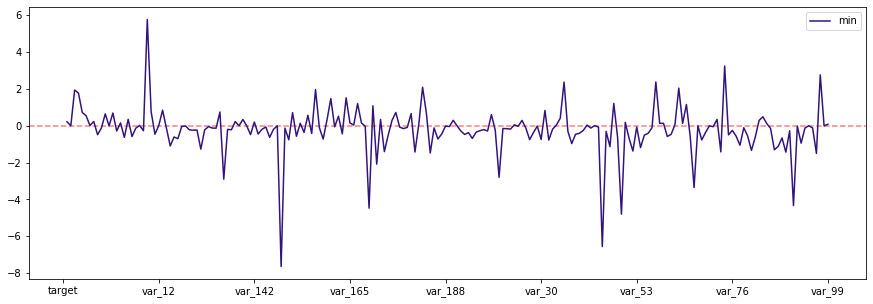

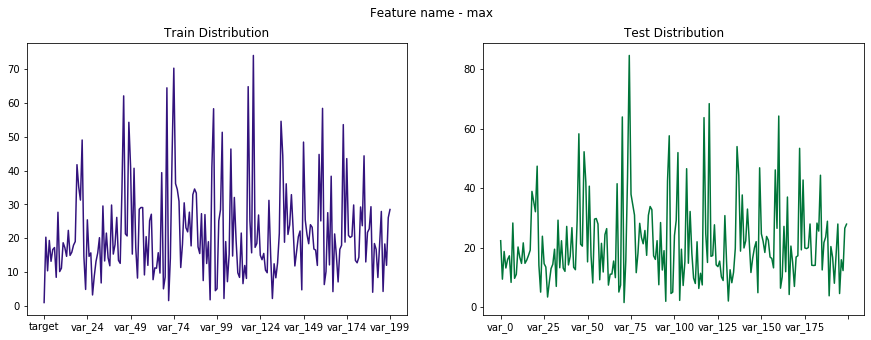

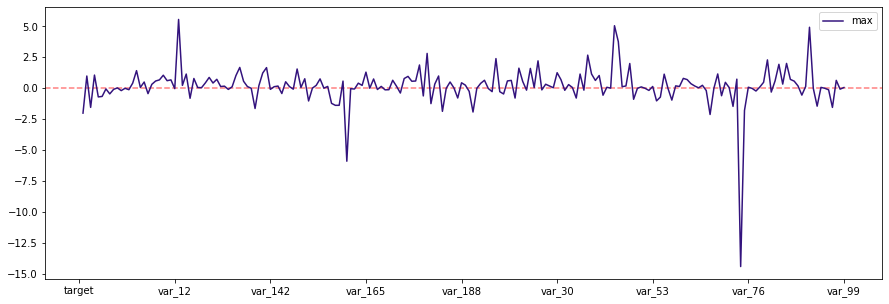

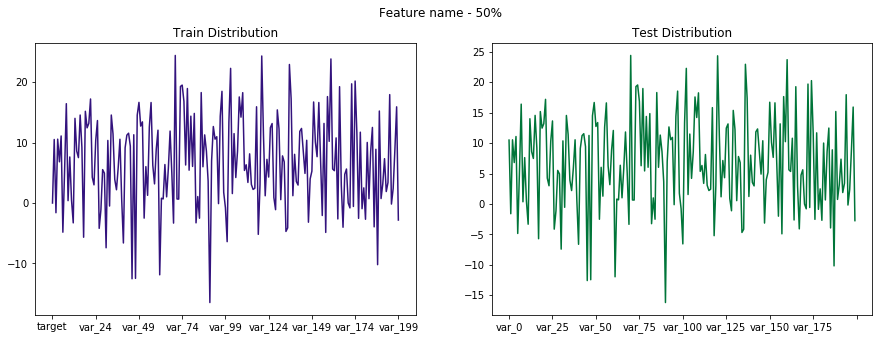

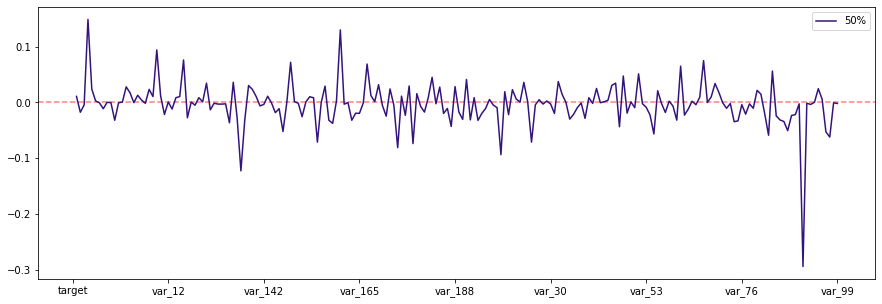

In [17]:
for feature in ["mean", "std", "min", "max", "50%"]:
    plot_stat_distribution(train_stats.loc[feature], test_stats.loc[feature])

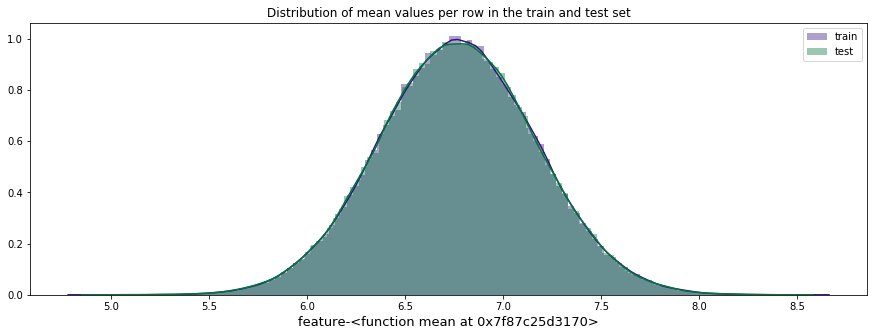

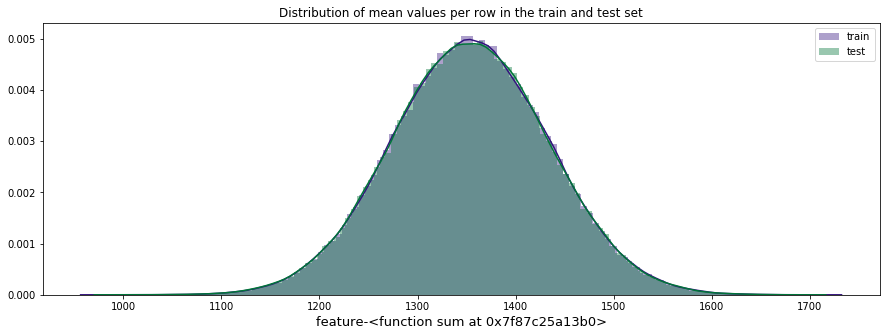

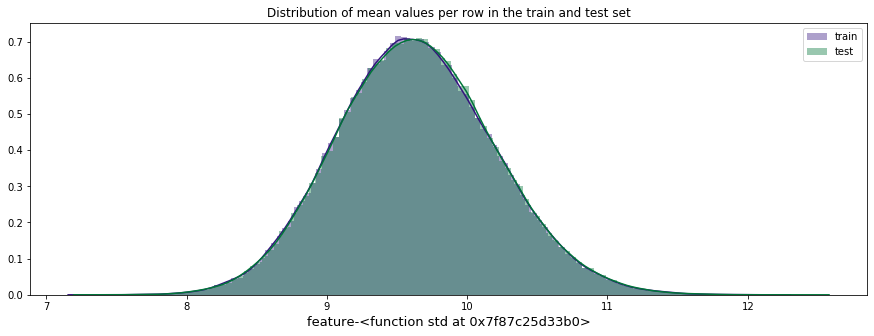

In [18]:
for func in [np.mean, np.sum, np.std]:
    plot_row_distribution(func, train, test)

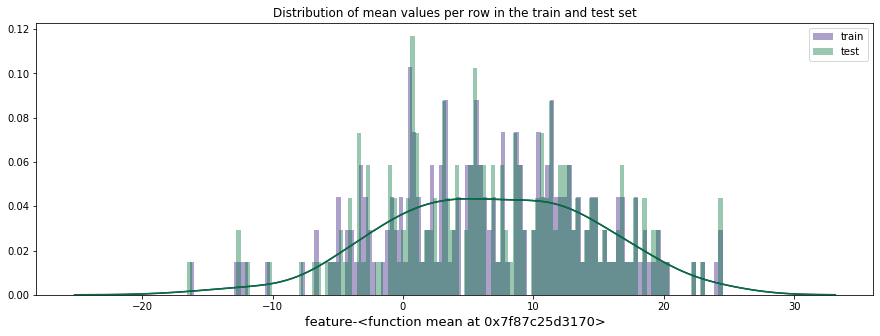

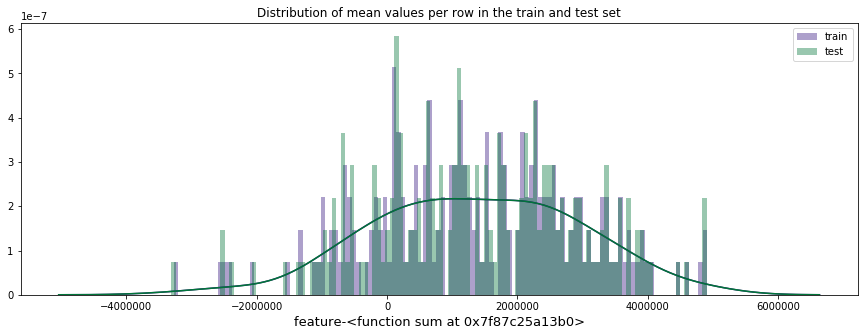

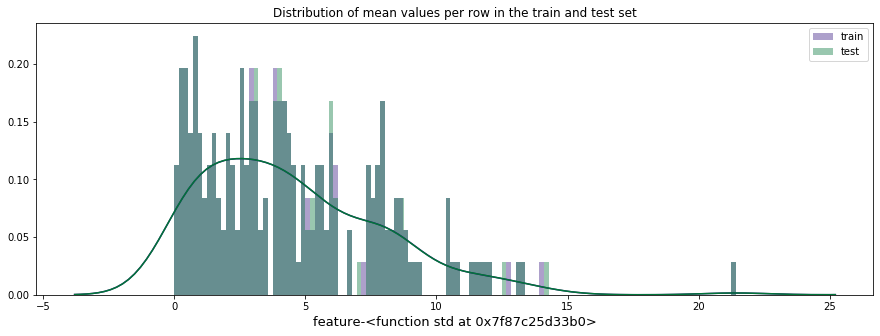

In [19]:
for func in [np.mean, np.sum, np.std]:
    plot_row_distribution(func, train, test, axis=0)

На основе этой визуализации можно сделать несколько выводоы:

* стандартное отклонение достаточно большое (по сравнению со средним значение); отклонение велико как для обучающих данных, так и для тестовых данных.

* распределения всех статистик на обучающих и на тестовых данных очень близки друг к другу; небольшие отличия наблюдаются только для статистики `min` и `max`.

* статистики по всем объектам сходятся, имеют одинаковое распределение. Выбросов по объектам, вероятно, нет.

## 2. Анализ целевой переменной

Mean-target: 0.1005


Text(0, 0.5, 'Index')

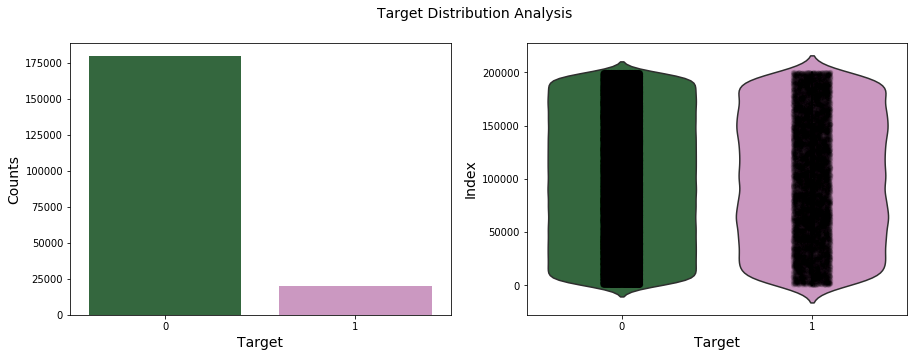

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Target Distribution Analysis", size=14)
print(f"Mean-target: {round(train.target.mean(), 4)}")

sns.countplot(train.target, ax=axes[0], palette="cubehelix")
sns.violinplot(train.target, train.index, ax=axes[1], palette="cubehelix")
sns.stripplot(train.target, train.index, jitter=True, ax=axes[1], color="black", alpha=0.05)

axes[0].set_xlabel("Target", fontsize=14)
axes[0].set_ylabel("Counts", fontsize=14)
axes[1].set_xlabel("Target", fontsize=14)
axes[1].set_ylabel("Index", fontsize=14)

Сделаем первые выводы о целевой переменной:

* мы будем решать задачи бинарной классификации с дисбалансом целевой переменной. Количество клиентов, которые совершили транзакцию, намного меньше, чем клиентов, которые транзакцию не совершали. При этом, дисбаланс не является критическим, а является вполне рабочей ситуацией. Какие-то манипуляции с данными для выравнивания баланса классов, в качестве приоритетных гипотез, рассматриваться не будут.

* взглянем на правый график: мы видим, что целевая переменная распределена равномерно по индексам датафрейма. Это говорит о том, что организаторы были очень внимательны при подготовке данных, сделали все, чтобы избежать лика в данных, и это может быть доказательством того, что данные были сгенерированы случайно / смоделированы специалным процессом.

## 3. Анализ распределения признаков

In [21]:
features = [
    f"var_{feature}" for feature in
    [0, 1, 2, 5, 9, 10, 13, 20, 26, 40, 55, 80, 106, 109, 124, 139, 150, 175, 184, 196]
]

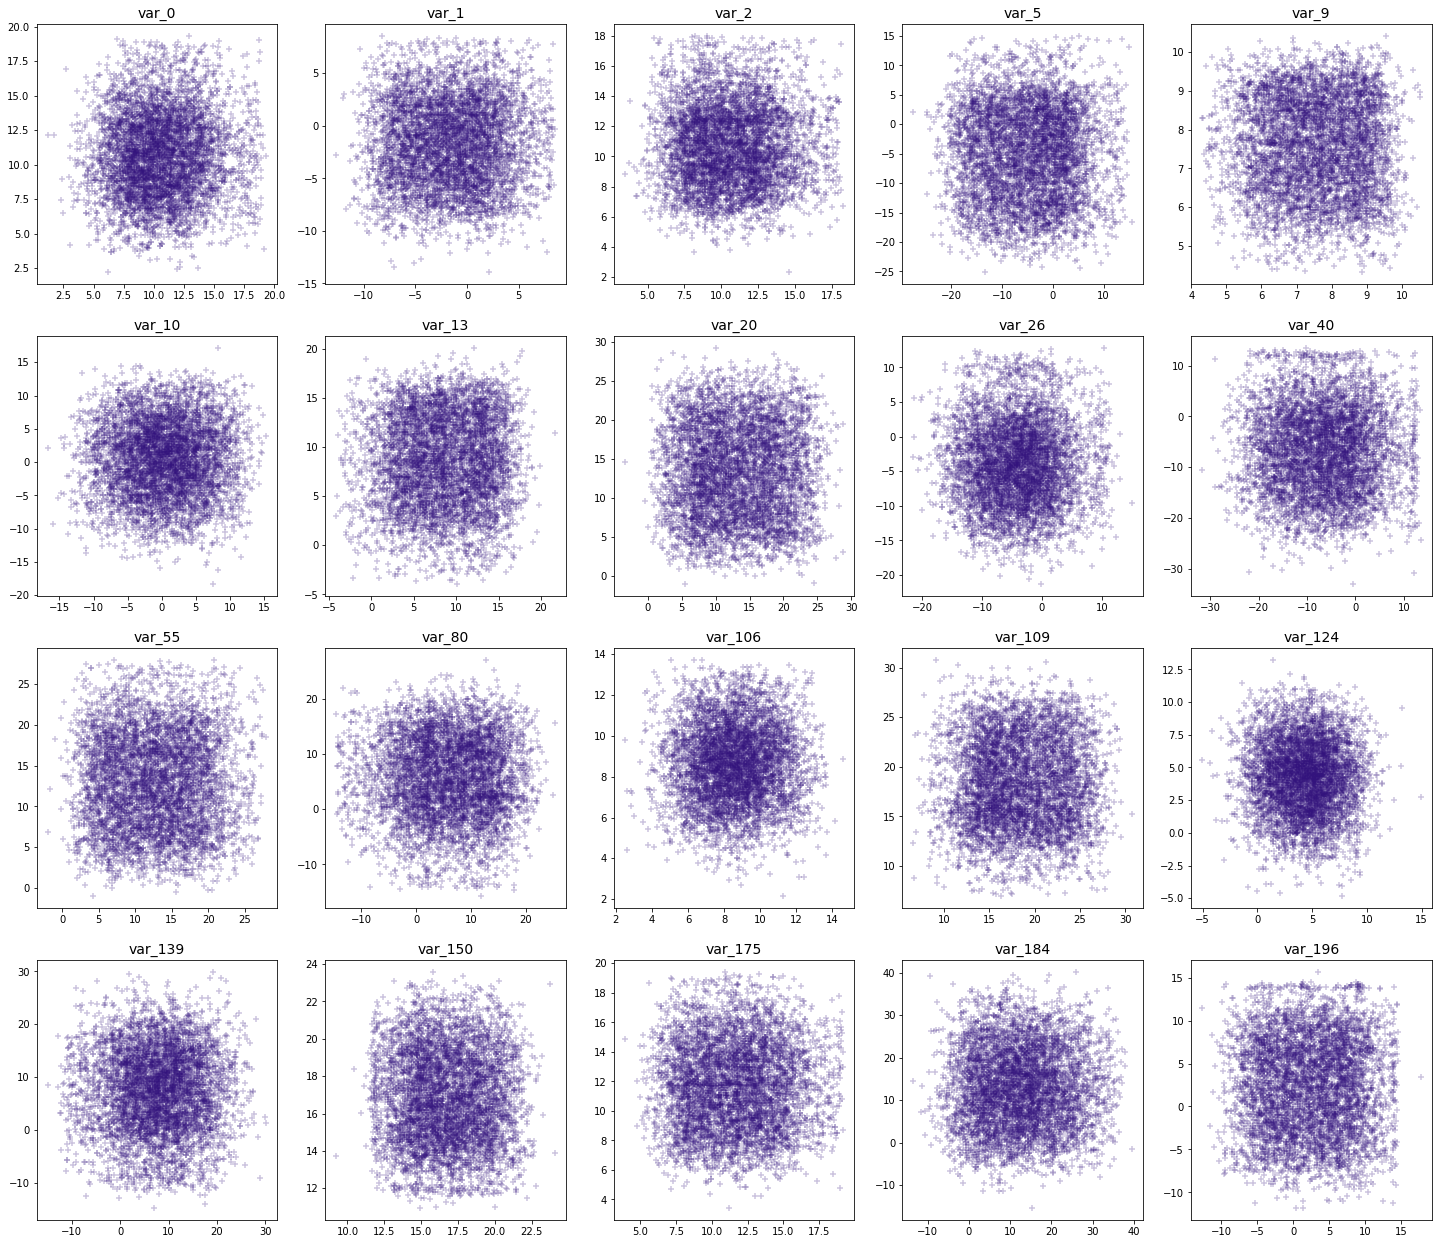

In [22]:
fig, axes = plt.subplots(4, 5, figsize=(25, 22))

for num, feature in enumerate(features, start=1):
    plt.subplot(4, 5, num)
    plt.title(f"{feature}", size=14)
    plt.scatter(
        train[feature].sample(5000),
        test[feature].sample(5000),
        color="#33137d",
        alpha=0.25,
        marker="+")

__Задание 3:__ построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

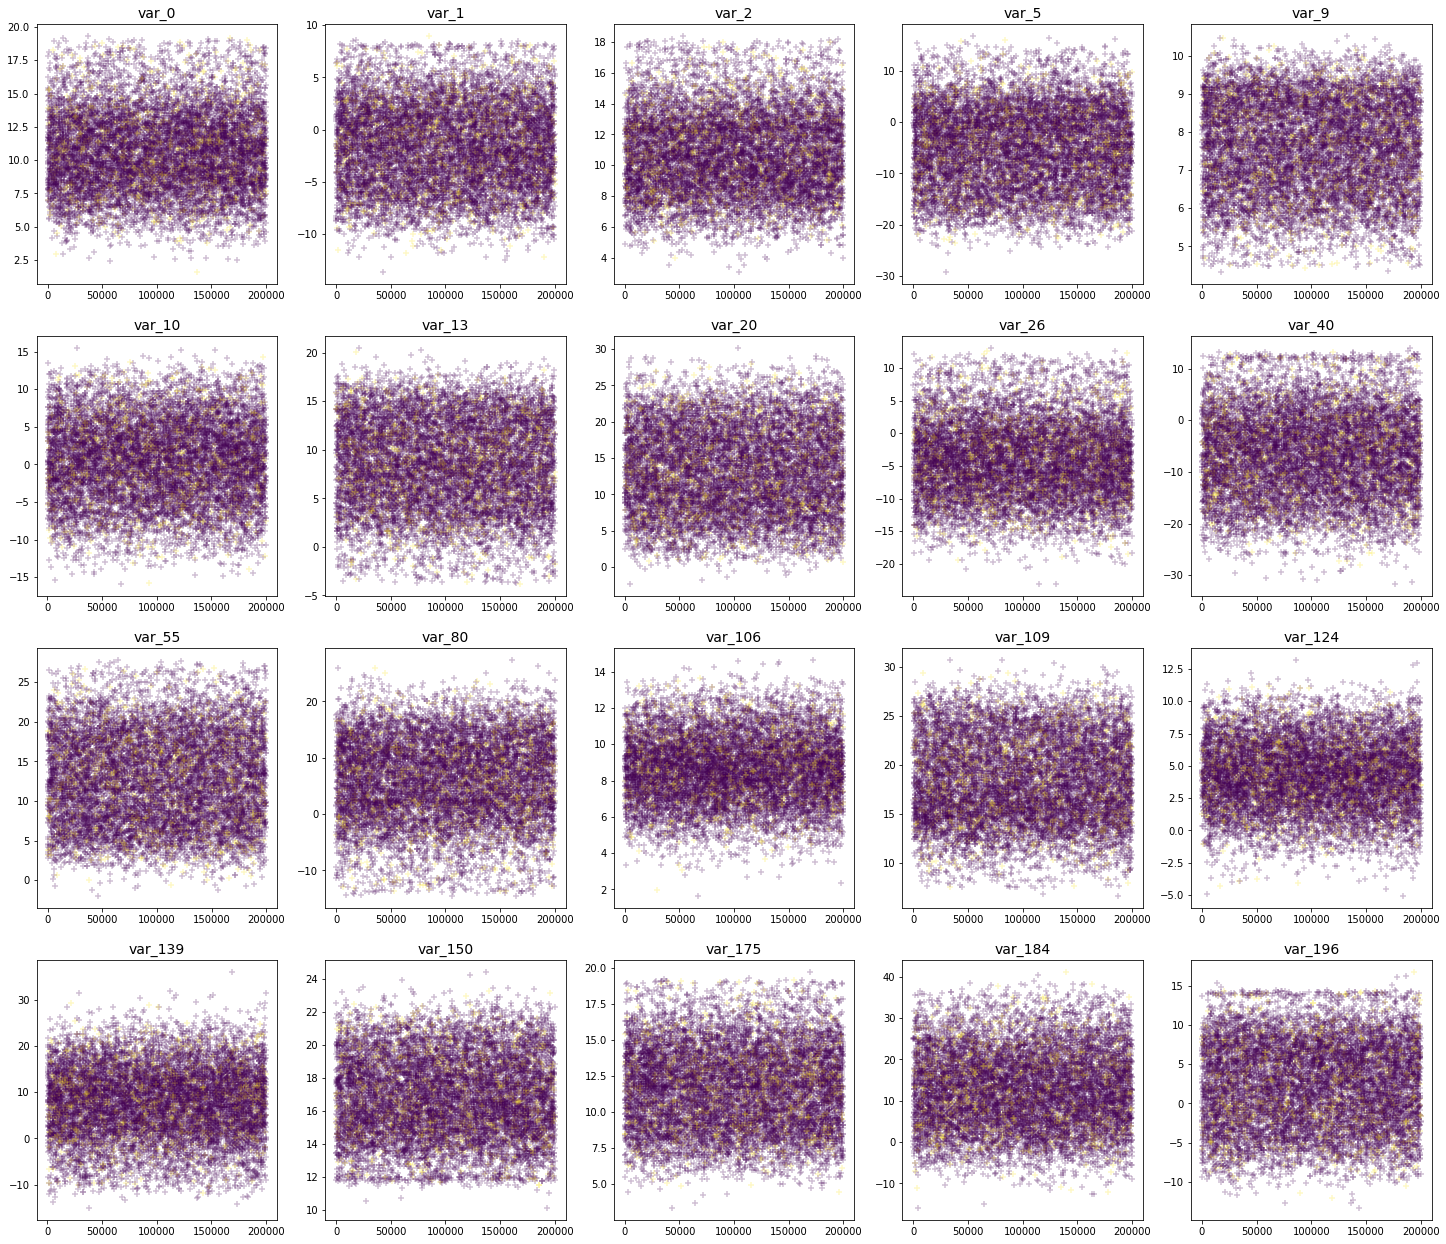

In [23]:
fig, axes = plt.subplots(4, 5, figsize=(25, 22))

for num, feature in enumerate(features, start=1):
    plt.subplot(4, 5, num)
    plt.title(f"{feature}", size=14)
    plt.scatter(
        train[feature].sample(10000).index,
        train[feature].sample(10000),
        c=train["target"].sample(10000),
        cmap="viridis",
        alpha=0.25,
        marker="+")

In [24]:
def plot_features_distribution(train: pd.DataFrame, test: pd.DataFrame, features: List[str]):
    """
    Построение графика распределения признака на обучающем и тестовом наборе данных.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Обучающая выборка.

    test: pandas.core.frame.DataFrame
        Тестовая выборка.

    features: List[str]
        Список с названеим признаков.

    """
    n_rows, n_cols = len(features)//5, 5
    if len(features) % 5:
        n_rows += 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_rows, 5*n_cols))
    for num, feature in enumerate(features, start=1):
        plt.subplot(n_rows, n_cols, num)
        statistic, pvalue = ks_2samp(train[feature].sample(5000), test[feature].sample(5000))
        plt.title(f"{feature}, p-value = {round(pvalue, 4)}", size=14)
        sns.distplot(train[feature], hist=False, color="#33137d")
        sns.distplot(test[feature], color="#007539", hist=False)

def plot_features_target_distribution(train: pd.DataFrame, target: pd.Series, features: List[str]):
    """
    Построение графика распределения признака для
    разных значений целевой переменной.

    Parameters
    ----------
    train: pandas.core.frame.DataFrame
        Обучающая выборка.

    target: pandas.core.frame.Series
        Вектор целевой переменной.

    features: List[str]
        Список с названеим признаков.

    """
    n_rows, n_cols = len(features)//5, 5
    if len(features) % 5:
        n_rows += 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_rows, 5*n_cols))
    for num, feature in enumerate(features, start=1):
        plt.subplot(n_rows, n_cols, num)
        positive_mask, negative_mask = target == 1, target == 0
        statistic, pvalue = ks_2samp(
            train.loc[positive_mask, feature].sample(5000),
            test.loc[negative_mask, feature].sample(5000)
        )
        plt.title(f"{feature}, p-value = {round(pvalue, 4)}", size=14)
        sns.distplot(train.loc[positive_mask, feature], hist=False, color="#33137d")
        sns.distplot(test.loc[negative_mask, feature], color="#007539", hist=False)

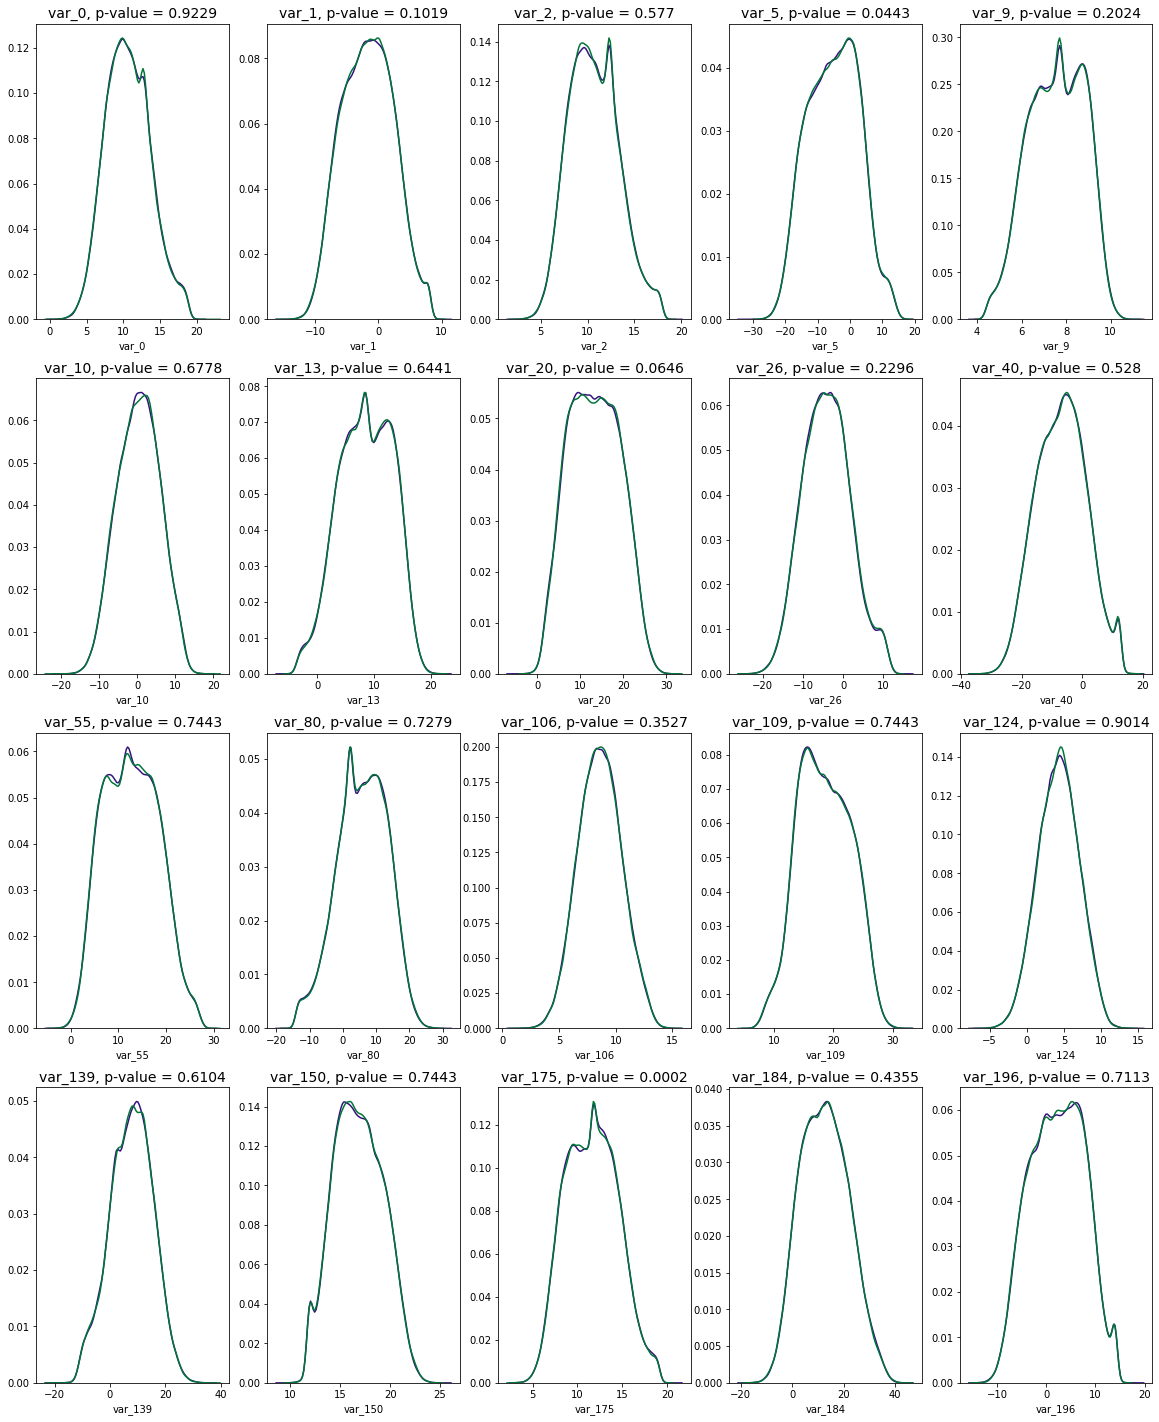

In [25]:
plot_features_distribution(train, test, features=features)

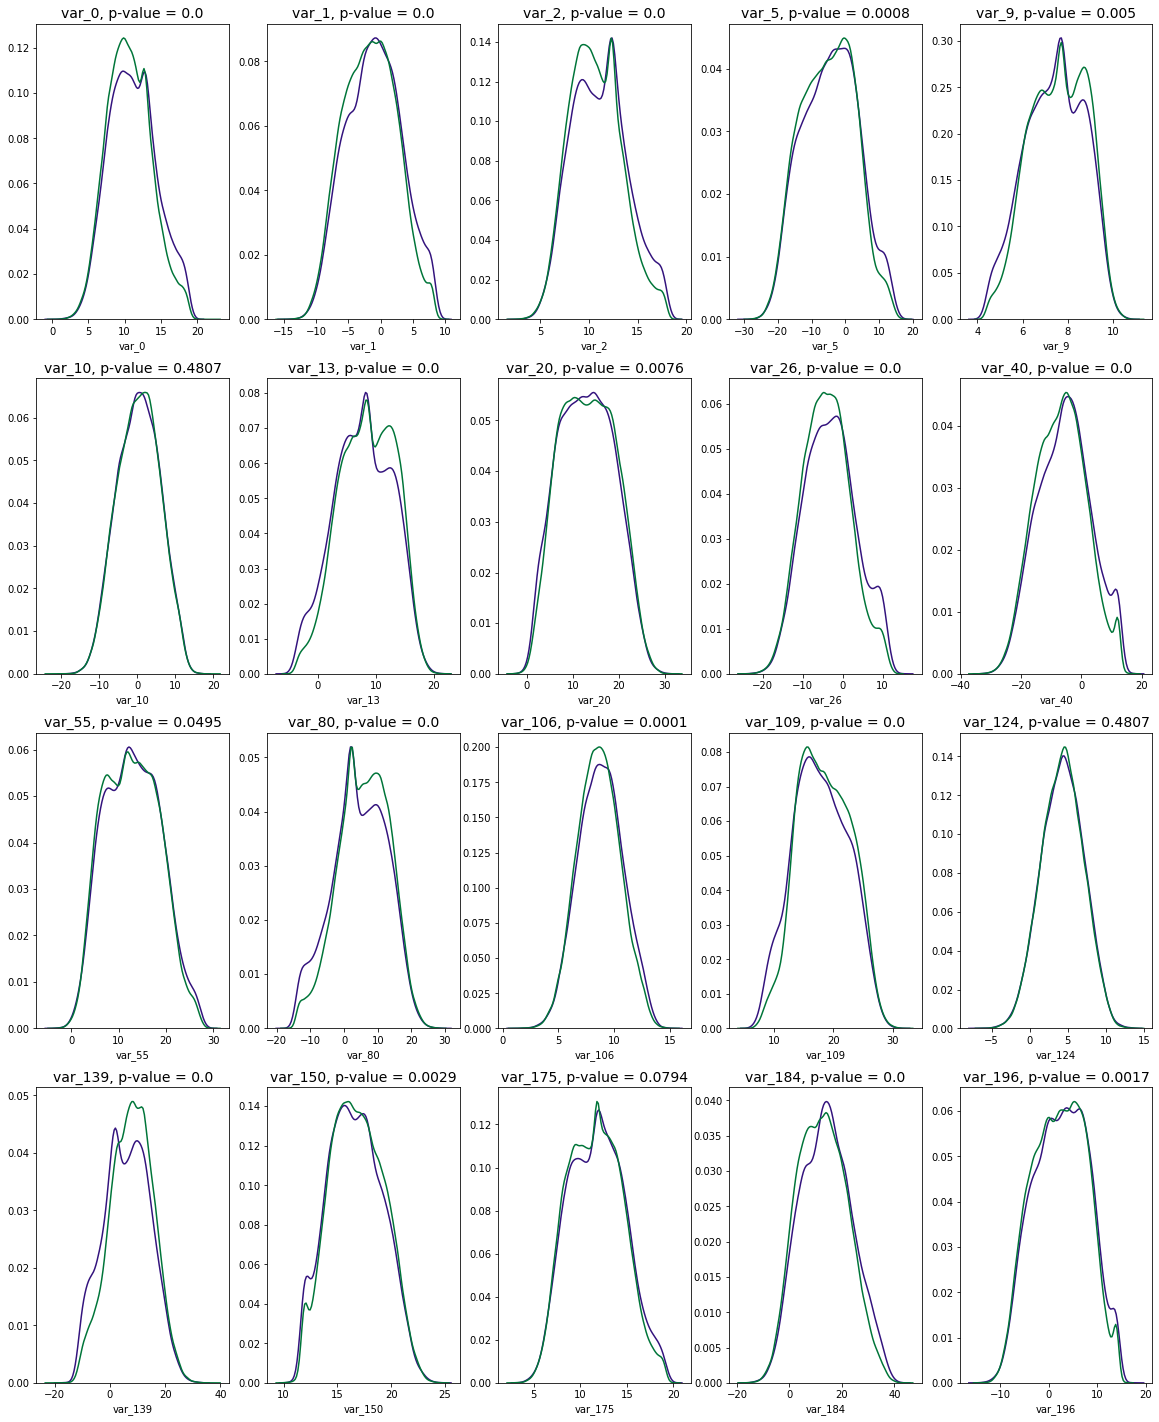

In [26]:
plot_features_target_distribution(train, train["target"], features=features)

Сделаем некоторые выводы о распределении признаков:

* распределение значений признаков по индексам однородное, распределение объектов целевого класса по признакам однородное, что еще раз подтверждает гипотезу о том, что данные смоделированы очень аккуратно, ликов в данных скорее всего нет, и данные могут иметь синтетическую природу;

* распределение значений признаков на обучающей выборки и на тестовой выборке очень близко, что позволяет надеятся на стабильные результаты на валидации / на лидерборде;

* в разрезе целевой переменной, по некотормы признаков выделяется очень большая разница в распределениях; например, для признаков __var_0__, __var_2__, __var_139__ распределение очень разное для объектов целевого класса и объектов фонового класса. При этом, по некоторым признакам, разница не очевидна, например для признаков __var_124__, __var_55__. Эти знания полезны для дальнейшего Feature Selection.

## 5. Связь между признаками

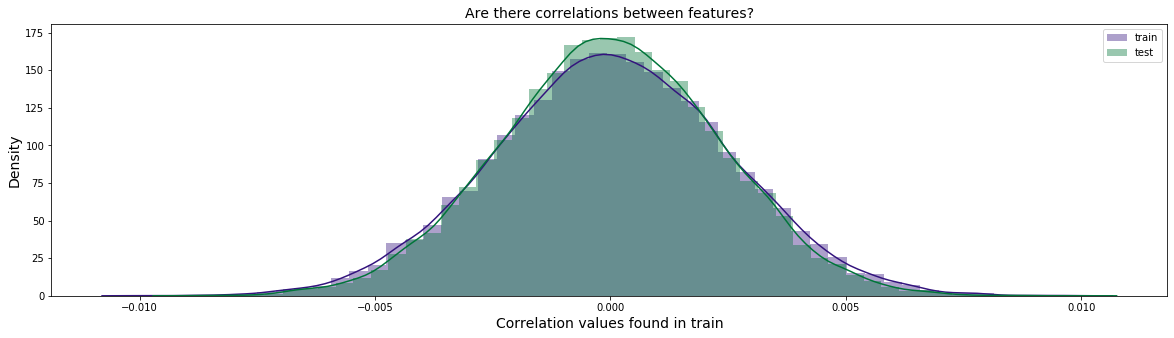

In [27]:
train_correlations = train.drop(["target"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="#33137d", label="train")
sns.distplot(test_correlations, color="#007539", label="test")
plt.title("Are there correlations between features?", size=14)
plt.xlabel("Correlation values found in train", size=14)
plt.ylabel("Density", size=14)
plt.legend()

Интересно! Коэффициент корреляции между всеми признаками близки к нулю, статистически не значимые результаты. Таким образом, все признаки не имеют линейной корреляции! Такая картина актуальна как для обучающей выборки, так и для тестовой выборки. Очень странно. Мы знаем, что данные являются анонимными, но это еще один (возможно последний?) факт в пользу того, что данные или были сгенерированы случайно или были специальным образом обработаны для максимального усложнения задачи Data Scientist'ам.

Воспользуемся, например, случайным лесом, чтобы выбрать 10 основных признаков, которые связаны нелинейно с целевой переменной. Они могут служить отправной точкой для раскрытия природы данных и попыток понять данные. Кроме того, они могут дать некоторые идеи о том, как создавать новые признаки. Будем использовать именно случайный лес, а не реализацию градиентого бустинга, потому что лес гораздо проще, он быстрее обучается и легке интерпретировать важность признаков случайного леса.

In [28]:
parameters = {
    "max_depth": [6, 8, 10, 15],
    "min_samples_leaf": [15, 25, 50, 100, 250]
}

model = RandomForestClassifier(
    n_estimators=100, n_jobs=6, random_state=27
)
grid = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,
    verbose=2,
    scoring=make_scorer(roc_auc_score),
    cv=3,
)

In [ ]:
%%time
grid.fit(
    train.drop(["target", "ID_code"], axis=1),
    train.target
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 149.6min


In [ ]:
ntop = 10
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = train.drop("target", axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

Отлично, мы поняли какие признаки связаны с целевой переменной нелинейно. Посмотрим на распределение этих признаков более детально. 

In [ ]:
fig, axes = plt.subplots(ntop, 2, figsize=(15, 5*ntop))

for n in range(ntop):
    sns.distplot(
        train.loc[train.target==0, feature_names[idx][n]],
        ax=axes[n, 0],
        color="#33137d",
        label="target=0",
        norm_hist=True,
    )
    sns.distplot(
        train.loc[train.target==1, feature_names[idx][n]],
        ax=axes[n, 0],
        color="#007539",
        label="target=1",
        norm_hist=True
    )
    sns.distplot(
        train.loc[:, feature_names[idx][n]],
        ax=axes[n, 1],
        color="#33137d", 
        norm_hist=True,
        label="train"
    )
    sns.distplot(
        test.loc[:, feature_names[idx][n]],
        ax=axes[n, 1],
        color="#007539",
        norm_hist=True,
        label="test"
    )

    axes[n, 0].set_title("Train {}".format(feature_names[idx][n]))
    axes[n, 1].set_title("Test {}".format(feature_names[idx][n]))
    axes[n, 0].set_xlabel("")
    plt.legend(loc="best")

In [ ]:
top_features = train[feature_names[idx]]
top_features = top_features.join(train.target)
sns.pairplot(top_features, hue="target", palette="cubehelix")

__Выводы:__

* Интересно, что на распределение признака при разном значении целевой переменной, накапливается некоторые пики, особенно для переменных __var_80__, __var_108__, __var_145__, __var_109__, __var_165__. Интересно, с чем это связано?

* Для тестовых данных такие пики менее наблюдаемы

* Очень интересно, что для большинства топовых признаков, объекты целевого класса лежат __строго внутри__ объектов фонового класса. Эта идея может быть очень полезной для генерации новых признаков, особенно с использованием перехода в другую систему координат.

## 7. Анализ распределения признаков на обучении и на тесте

In [69]:
x_adv = pd.concat([
    train.drop("target", axis=1), test
])
x_adv = x_adv.reset_index(drop=True)
x_adv = x_adv.drop("ID_code", axis=1)

In [64]:
y_adv = np.hstack((
    np.zeros(train.shape[0]),
    np.ones(test.shape[0])
))

In [70]:
cv = cross_val_score(
    estimator=xgb.XGBClassifier(n_estimators=25),
    X=x_adv, y=y_adv, cv=5, scoring="roc_auc"
)

In [71]:
print(f"CV-mean: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

CV-mean: 0.5105 +/- 0.001
